# Práctica 3.4 – Comparación PCA vs Robust PCA en imágenes

Objetivo: comparar distintos modelos de PCA. 

1. PCA estándar “a mano” (SVD + autovectores principales)

2. Robust PCA (RPCA) usando CVXPY (descomposición bajo rango + sparse)

3. PCA de librerías (sklearn)

El contexto elegido es una imagen con ruido impulsivo (salt & pepper / outliers), donde PCA estándar falla y Robust PCA brilla. Este ejemplo es clásico y muy visual.

## 1. Imports y configuración

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

from sklearn.decomposition import PCA
from skimage import data
from skimage.util import random_noise


(CVXPY) Dec 15 10:09:44 PM: Encountered unexpected exception importing solver CVXOPT:
ImportError('DLL load failed while importing base: No se puede encontrar el módulo especificado.')
(CVXPY) Dec 15 10:09:44 PM: Encountered unexpected exception importing solver GLPK:
ImportError('DLL load failed while importing base: No se puede encontrar el módulo especificado.')
(CVXPY) Dec 15 10:09:44 PM: Encountered unexpected exception importing solver GLPK_MI:
ImportError('DLL load failed while importing base: No se puede encontrar el módulo especificado.')


## 2. Cargar imagen y crear corrupción con outliers

### Usamos una imagen real y añadimos ruido impulsivo, que no es gaussiano.

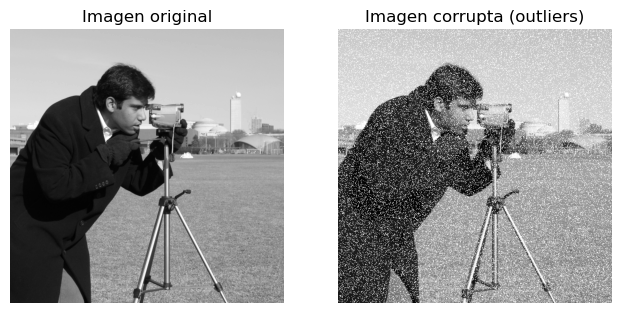

In [3]:
# Imagen en escala de grises
image = data.camera().astype(float)
image = image / 255.0  # Normalizar

# Añadir ruido impulsivo (outliers)
corrupted = random_noise(image, mode='salt', amount=0.15)

# Visualización
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Imagen original")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Imagen corrupta (outliers)")
plt.imshow(corrupted, cmap='gray')
plt.axis('off')

plt.show()


## 3. Preparar datos para PCA

Cada fila es una observación, cada columna un píxel.

In [5]:
X = corrupted
n_rows, n_cols = X.shape


## 4. PCA estándar “a mano” (SVD)

In [13]:
# Centrar los datos
X_mean = np.mean(X, axis=0)
X_centered = X - X_mean

# SVD
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

# Número de componentes
rank = 50

# Reconstrucción PCA
X_pca_manual = U[:, :rank] @ np.diag(S[:rank]) @ Vt[:rank, :] + X_mean


## 5. PCA con scikit-learn

In [7]:
pca = PCA(n_components=rank)
X_pca_sklearn = pca.fit_transform(X)
X_pca_sklearn = pca.inverse_transform(X_pca_sklearn)

## 6. Robust PCA con CVXPY

In [8]:
# Parámetro recomendado
lam = 1 / np.sqrt(max(n_rows, n_cols))

# Variables
L = cp.Variable((n_rows, n_cols))
S = cp.Variable((n_rows, n_cols))

# Problema de optimización
objective = cp.Minimize(cp.normNuc(L) + lam * cp.norm1(S))
constraints = [X == L + S]

problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.SCS, verbose=True)

L_rpca = L.value
S_rpca = S.value


                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) Dec 15 10:11:18 PM: Your problem has 524288 variables, 1 constraints, and 0 parameters.
(CVXPY) Dec 15 10:11:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 15 10:11:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 15 10:11:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 15 10:11:18 PM: Compiling problem (target solver=SCS).
(CVXPY) Dec 15 10:11:18 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

## 7. Visualización comparativa

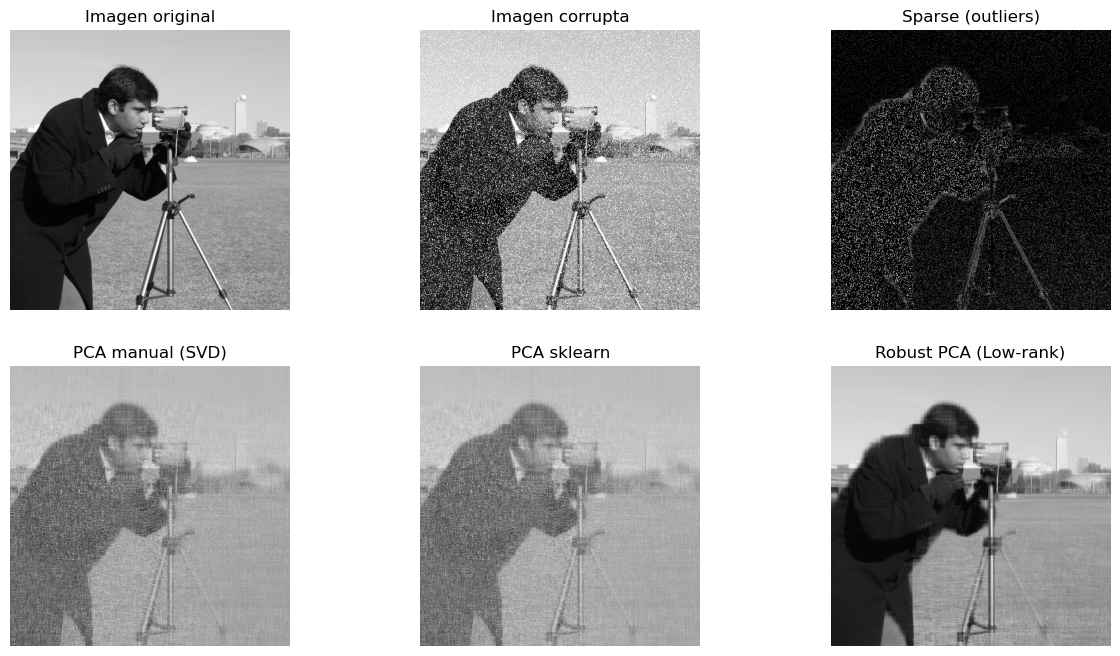

In [9]:
plt.figure(figsize=(15,8))

plt.subplot(2,3,1)
plt.title("Imagen original")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(2,3,2)
plt.title("Imagen corrupta")
plt.imshow(corrupted, cmap='gray')
plt.axis('off')

plt.subplot(2,3,3)
plt.title("Sparse (outliers)")
plt.imshow(np.abs(S_rpca), cmap='gray')
plt.axis('off')

plt.subplot(2,3,4)
plt.title("PCA manual (SVD)")
plt.imshow(X_pca_manual, cmap='gray')
plt.axis('off')

plt.subplot(2,3,5)
plt.title("PCA sklearn")
plt.imshow(X_pca_sklearn, cmap='gray')
plt.axis('off')

plt.subplot(2,3,6)
plt.title("Robust PCA (Low-rank)")
plt.imshow(L_rpca, cmap='gray')
plt.axis('off')

plt.show()


## 8. Robust PCA vía IALM






In [16]:
def soft_threshold(X, tau):
    return np.sign(X) * np.maximum(np.abs(X) - tau, 0)

    
def robust_pca_ialm(X, lam=None, mu=None, tol=1e-7, max_iter=1000):
    """
    Robust PCA via Inexact Augmented Lagrangian Method (IALM)
    """

    m, n = X.shape
    normX = np.linalg.norm(X, ord='fro')

    if lam is None:
        lam = 1 / np.sqrt(max(m, n))

    if mu is None:
        mu = (m * n) / (4 * np.sum(np.abs(X)))

    L = np.zeros_like(X)
    S = np.zeros_like(X)
    Y = np.zeros_like(X)

    for it in range(max_iter):

        # --- Update L (SVT)
        U, sigma, Vt = np.linalg.svd(X - S + (1/mu)*Y, full_matrices=False)
        sigma_thresh = np.maximum(sigma - 1/mu, 0)
        rank = np.sum(sigma_thresh > 0)
        L = U[:, :rank] @ np.diag(sigma_thresh[:rank]) @ Vt[:rank, :]

        # --- Update S (soft threshold)
        S = soft_threshold(X - L + (1/mu)*Y, lam/mu)

        # --- Dual update
        Z = X - L - S
        Y = Y + mu * Z

        # --- Convergence check
        err = np.linalg.norm(Z, ord='fro') / normX
        if err < tol:
            print(f"Converged in {it} iterations.")
            break

    return L, S

In [17]:
L_rpca, S_rpca = robust_pca_ialm(X)